# Testing cancelation of SRG transformations in momentum distributions

__Author:__ A. J. Tropiano [atropiano@anl.gov]<br/>
__Date:__ February 9, 2023

The SRG transformations are unitary and therefore satisfy the condition<br>

$$
\begin{align}
U^\dagger U &= I + \frac{1}{4} \sum_{\mathbf{k}, \mathbf{k'}, \mathbf{K}} \bigl[
    \delta U(\mathbf{k},\mathbf{k'}) + \delta U^\dagger(\mathbf{k},\mathbf{k'})
    + \frac{1}{2} \sum_{\mathbf{k''}} \delta U(\mathbf{k},\mathbf{k''}) \delta U^\dagger(\mathbf{k''},\mathbf{k'})
\bigr]
a^\dagger_{\frac{\mathbf{K}}{2}+\mathbf{k}} a^\dagger_{\frac{\mathbf{K}}{2}-\mathbf{k}}
a_{\frac{\mathbf{K}}{2}-\mathbf{k'}} a_{\frac{\mathbf{K}}{2}+\mathbf{k'}} \\
&= I
.
\end{align}
$$<br>

This implies that<br>

$$
\delta U(\mathbf{k},\mathbf{k'}) + \delta U^\dagger(\mathbf{k},\mathbf{k'}) 
+ \frac{1}{2} \sum_{\mathbf{k''}} \delta U(\mathbf{k},\mathbf{k''}) \delta U^\dagger(\mathbf{k''},\mathbf{k'})
= 0
.
$$<br>

In partial waves this looks like<br>

$$
\delta U_{LL'}(k,k') + \delta U^\dagger_{LL'}(k,k') + \frac{2}{\pi} \sum_{L''} \int dk'' k''^2
    \delta U_{LL''}(k,k'') \delta U^\dagger_{L''L'}(k'',k')
= 0
,
$$<br>
given partial wave channel quantum numbers $J$, $S$, and $T$.<br>

_Last update:_ February 22, 2023

In [1]:
# Python imports
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import numpy.linalg as la
from scipy.interpolate import RectBivariateSpline

In [2]:
# Imports from scripts
from scripts.figures import interpolate_matrix, label_ticks, set_rc_parameters
from scripts.integration import unattach_weights_from_matrix
from scripts.momentum_projection_operator import momentum_projection_operator
from scripts.potentials import Potential
from scripts.srg import get_transformation

In [3]:
import test_momentum_distribution_script as tmds

In [4]:
# Run this cell to turn on customized matplotlib graphics
set_rc_parameters()

## Check partial wave basis first

In [5]:
kvnn = 6
channel = '3S1'
# channel = '3P1'
# channel = '1P1'
kmax, kmid, ntot = 15.0, 3.0, 120
generator, lamb = 'Wegner', 1.35

potential = Potential(kvnn, channel, kmax, kmid, ntot)
k_array, k_weights = potential.load_mesh()

In [6]:
# Initial and evolved Hamiltonians with integration factors attached [MeV]
H_initial = potential.load_hamiltonian()
H_evolved = potential.load_hamiltonian('srg', generator, lamb)

# SRG transformation with integration factors attached [unitless]
U_matrix = get_transformation(H_initial, H_evolved)

# Identity matrix
I_matrix = np.eye(len(U_matrix), len(U_matrix))

In [7]:
# \delta U and \delta U^\dagger matrices
delta_U = U_matrix - I_matrix
delta_U_dag = (U_matrix - I_matrix).T

In [8]:
# \delta U 3S1-3S1 sub-block
delta_U_3S1_3S1 = delta_U[:ntot, :ntot]

# \delta U^\dagger 3S1-3S1 sub-block
delta_U_dag_3S1_3S1 = delta_U_dag[:ntot, :ntot]

# \delta U 3S1-3D1 sub-block
delta_U_3S1_3D1 = delta_U[:ntot, ntot:]

# \delta U^\dagger 3D1-3S1 sub-block
delta_U_dag_3D1_3S1 = delta_U_dag[ntot:, :ntot]

In [9]:
# \sum_k'' \delta U_{3S1-3S1}(k,k'') \delta U^\dagger_{3S1-3S1}(k'',k')
delta_U2_3S1_3S1 = delta_U_3S1_3S1 @ delta_U_dag_3S1_3S1

# \sum_k'' \delta U_{3S1-3D1}(k,k'') \delta U^\dagger_{3D1-3S1}(k'',k')
delta_U2_3S1_3D1 = delta_U_3S1_3D1 @ delta_U_dag_3D1_3S1

In [10]:
matrix = delta_U_3S1_3S1 + delta_U_dag_3S1_3S1 + (delta_U2_3S1_3S1
                                                  + delta_U2_3S1_3D1)
print(matrix)
print(f"Norm of matrix with integration weights = {la.norm(matrix):.5f}.\n")
matrix_no_weights = unattach_weights_from_matrix(k_array, k_weights, matrix)

[[ 1.37124797e-16 -6.72870069e-19 -2.36931990e-18 ...  2.61876283e-19
  -1.68191875e-19 -2.78987341e-19]
 [-6.72870069e-19 -3.18412258e-16 -5.60478790e-17 ...  9.08208115e-17
   1.39631340e-16 -2.41429877e-16]
 [-2.36931990e-18 -5.60478790e-17 -2.62526099e-15 ... -8.27006309e-17
   4.38564212e-17  6.62542554e-18]
 ...
 [ 2.61876283e-19  9.08208115e-17 -8.27006309e-17 ...  9.99200722e-16
  -2.22044605e-16 -9.57567359e-16]
 [-1.68191875e-19  1.39631340e-16  4.38564212e-17 ... -2.22044605e-16
  -5.55111512e-16 -1.76247905e-15]
 [-2.78987341e-19 -2.41429877e-16  6.62542554e-18 ... -9.57567359e-16
  -1.76247905e-15  9.71445147e-17]]
Norm of matrix with integration weights = 0.00000.



In [11]:
def plot_delU_sum(
        k_array, matrix_no_weights, levels_number=61,
        colorbar_limits=(-1.0,1.0), color_map='turbo', axes_limits=(0.0,4.0),
        xlabel_size=16, ylabel_size=16
):
    
    # --- Figure set-up --- #
    plt.close('all')
    f, ax = plt.subplots(figsize=(4,4))
    
    # Set contour levels
    levels = np.linspace(colorbar_limits[0], colorbar_limits[1],
                         levels_number)
    
    # We don't need the second output since it'll be the same as the first
    k_max = axes_limits[1] + 0.2  # Add a little extra to prevent white edges
    k_array_dense, _, matrix_dense = interpolate_matrix(
        k_array, k_array, matrix_no_weights, k_max, k_max)

    # --- Plot --- #
    c = ax.contourf(k_array_dense, k_array_dense, matrix_dense, levels,
                    cmap=color_map, extend='both')

    # --- Axes limits --- #
    ax.set_xlim(axes_limits)
    ax.set_ylim(axes_limits)

    # --- Axes labels --- #
    ax.set_xlabel("$k'$ [fm" + r"$^{-1}$" + "]", fontsize=xlabel_size)
    ax.set_ylabel("$k$ [fm" + r"$^{-1}$" + "]", fontsize=ylabel_size)
    
    # --- Adjust axes --- #
    # Switch x-axis label from bottom to top
    ax.xaxis.set_label_position('top')
    ax.tick_params(labeltop=True, labelbottom=False)
    # Invert y-axis
    ax.invert_yaxis()
    
    # --- Colorbar --- #
    # Colorbar location (left, bottom, width, height)
    cbar_ax = f.add_axes((1.0, 0.15, 0.1, 0.7))
    # Set colorbar ticks and tick labels
    levels_ticks = np.linspace(colorbar_limits[0], colorbar_limits[1], 9)
    levels_ticks_strings = label_ticks(levels_ticks)  # Make these strings
    # Set colorbar
    cbar = f.colorbar(c, cax=cbar_ax, ticks=levels_ticks)
    cbar.ax.set_yticklabels(levels_ticks_strings)
    cbar.ax.set_title(r"[fm$^3$]", fontsize=16, pad=15)

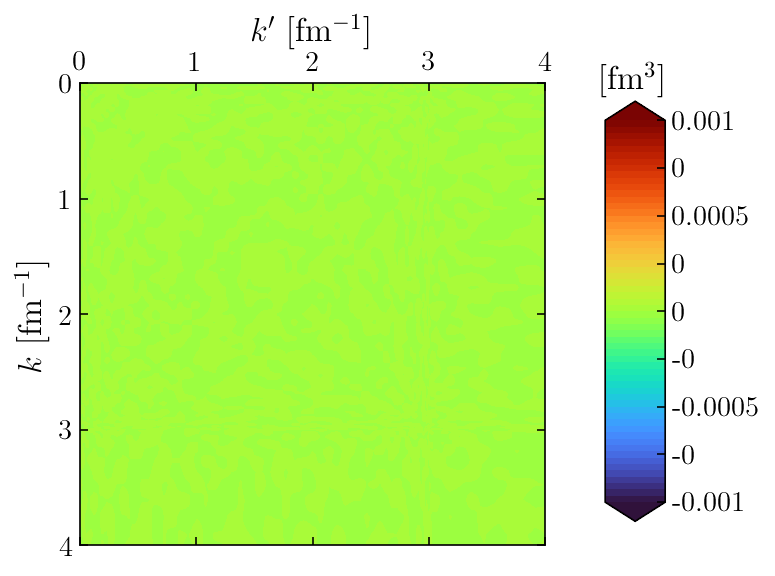

In [12]:
plot_delU_sum(
    k_array, matrix_no_weights, colorbar_limits=(-0.001,0.001),
    axes_limits=(0.0,4.0), xlabel_size=16, ylabel_size=16
)

The above plot shows
$$
\delta U(\mathbf{k},\mathbf{k'}) + \delta U^\dagger(\mathbf{k},\mathbf{k'}) 
+ \frac{1}{2} \sum_{\mathbf{k''}} \delta U(\mathbf{k},\mathbf{k''}) \delta U^\dagger(\mathbf{k''},\mathbf{k'})
$$
where integration factors have been divided out.

In [13]:
# delta_U_3S1_3S1_no_weights = unattach_weights_from_matrix(k_array, k_weights,
#                                                           delta_U_3S1_3S1)
# delta_U_dag_3S1_3S1_no_weights = unattach_weights_from_matrix(
#     k_array, k_weights, delta_U_dag_3S1_3S1
# )
# delta_U_linear = delta_U_3S1_3S1_no_weights + delta_U_dag_3S1_3S1_no_weights

In [14]:
# plot_delU_sum(
#     k_array, delta_U_3S1_3S1_no_weights, colorbar_limits=(-0.5,0.5),
#     axes_limits=(0.0,4.0), xlabel_size=16, ylabel_size=16
# )

In [15]:
# plot_delU_sum(
#     k_array, delta_U_dag_3S1_3S1_no_weights, colorbar_limits=(-0.5,0.5),
#     axes_limits=(0.0,4.0), xlabel_size=16, ylabel_size=16
# )

In [16]:
# plot_delU_sum(
#     k_array, delta_U_linear, colorbar_limits=(-0.5,0.5), axes_limits=(0.0,4.0),
#     xlabel_size=16, ylabel_size=16
# )

In [17]:
# delta_U2_no_weights = unattach_weights_from_matrix(
#     k_array, k_array, 1/2*(delta_U2_3S1_3S1 + delta_U2_3S1_3D1)
# )

# plot_delU_sum(
#     k_array, delta_U2_no_weights, colorbar_limits=(-0.1,0.1),
#     axes_limits=(0.0,4.0), xlabel_size=16, ylabel_size=16
# )

In [18]:
# print((I_matrix+delta_U) @ (I_matrix+delta_U).T)

In [19]:
# print(I_matrix @ I_matrix + delta_U @ I_matrix + I_matrix @ delta_U_dag + delta_U @ delta_U_dag)

In [20]:
print(delta_U @ I_matrix + I_matrix @ delta_U_dag + delta_U @ delta_U_dag)

[[ 1.37124797e-16 -6.72870069e-19 -2.36931990e-18 ...  1.12941917e-18
  -2.11705297e-19  4.52533970e-20]
 [-6.72870069e-19 -3.18412258e-16 -5.60478790e-17 ...  1.83677877e-16
  -2.33320255e-17  6.40432347e-18]
 [-2.36931990e-18 -5.60478790e-17 -2.62526099e-15 ... -4.88261555e-18
  -1.20545441e-16  9.75995302e-17]
 ...
 [ 1.12941917e-18  1.83677877e-16 -4.88261555e-18 ...  8.32667268e-17
  -3.33066907e-16 -5.30825384e-16]
 [-2.11705297e-19 -2.33320255e-17 -1.20545441e-16 ... -3.33066907e-16
   2.56739074e-16 -5.96744876e-16]
 [ 4.52533970e-20  6.40432347e-18  9.75995302e-17 ... -5.30825384e-16
  -5.96744876e-16 -1.42247325e-16]]


## Check that normalization of momentum projection operator is conserved

In [21]:
q = 2.0
mpo_initial = momentum_projection_operator(
    q, k_array, k_weights, coupled=potential.coupled_channel_bool
)

print(f"Unevolved norm = {la.norm(mpo_initial)}")

mpo_I_matrix = I_matrix @ mpo_initial @ I_matrix
mpo_delU_matrix = delta_U @ mpo_initial @ I_matrix
mpo_delUdag_matrix = I_matrix @ mpo_initial @ delta_U_dag
mpo_delU2_matrix = delta_U @ mpo_initial @ delta_U_dag

mpo_evolved = (mpo_I_matrix + mpo_delU_matrix + mpo_delUdag_matrix
               + mpo_delU2_matrix)

print(f"Evolved norm = {la.norm(mpo_evolved)}")

Unevolved norm = 2.847882658769522
Evolved norm = 2.8478826587695085


## Cancelation after interpolating $\delta U$ functions

In [24]:
# Check that \delta U_{3S1-3S1} * \delta U^\dagger_{3S1-3S1} is equal to
# \delta U_{3S1-3S1}^2

delU_3S1_3S1 = unattach_weights_from_matrix(k_array, k_weights, delta_U_3S1_3S1)

delUdag_3S1_3S1 = unattach_weights_from_matrix(k_array, k_weights,
                                               delta_U_dag_3S1_3S1)
# product = delU_3S1_3S1 * delUdag_3S1_3S1

# product_weights = (delta_U @ delta_U_dag)[:ntot,:ntot]
# product = unattach_weights_from_matrix(k_array, k_weights, product_weights)

# product = unattach_weights_from_matrix(k_array, k_weights, delta_U2_3S1_3S1)

product = np.zeros_like(delU_3S1_3S1)
for i in range(ntot):
    for j in range(ntot):
        product[i,j] = delU_3S1_3S1[i,j] * delUdag_3S1_3S1[j,i]

print(delU_3S1_3S1**2-product)

[[ 0.00000000e+00  2.27373675e-13  0.00000000e+00 ...  4.03896783e-28
   0.00000000e+00  4.03896783e-28]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
  -4.03896783e-28 -4.03896783e-28]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  4.03896783e-28
   0.00000000e+00 -4.03896783e-28]
 ...
 [ 0.00000000e+00 -2.06795153e-25  0.00000000e+00 ...  0.00000000e+00
   4.33680869e-19  0.00000000e+00]
 [ 1.03397577e-25  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.03397577e-25  0.00000000e+00  0.00000000e+00 ...  1.08420217e-19
   0.00000000e+00  0.00000000e+00]]


In [25]:
# Do the same test for the 3S1-3D1 block
delU_3S1_3D1 = unattach_weights_from_matrix(k_array, k_weights, delta_U_3S1_3D1)
delUdag_3D1_3S1 = unattach_weights_from_matrix(k_array, k_weights,
                                               delta_U_dag_3D1_3S1)
# print(delU_3S1_3D1*delUdag_3D1_3S1)
# print(delU_3S1_3D1**2)

product = np.zeros_like(delU_3S1_3D1)
for i in range(ntot):
    for j in range(ntot):
        product[i,j] = delU_3S1_3D1[i,j] * delUdag_3D1_3S1[j,i]
        
print(delU_3S1_3D1**2-product)

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -1.29246971e-26
   0.00000000e+00 -1.29246971e-26]
 [ 0.00000000e+00  0.00000000e+00  2.64697796e-23 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00 -1.50463277e-36 ...  0.00000000e+00
  -2.71050543e-20  2.71050543e-20]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  9.40395481e-38  3.00926554e-36 ... -2.71050543e-20
   3.38813179e-21  0.00000000e+00]]
